In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as st

In [3]:
df = pd.read_csv("/content/drive/MyDrive/ProbEstatistica/Grupo1/data_center_prob_estat_LIMPO_INTERPOLADO.csv", delimiter = ";")

In [ ]:
df.head() #para ver as 5 primeiras linhas da tabela

In [ ]:
#As casas decimais vieram meio zoadas nesse dataframe tratado, aí só converti de volta pra ordem de grandeza original

dict_convert_back = {
    "temp_ambiente_C":2,
    "uso_cpu_%":2,
    "uso_ram_%":2,
    "demanda_energia_kW":3,
    "pressao_resfriamento_bar":1,
    "consumo_agua_m3":1

}

for key, n in dict_convert_back.items():
    s = df[key].astype(str)
    df[key] = (s.str[:n] + "." + s.str[n:]).astype(float)

tens = ["hora_dia","dia_semana","reqs","trafego_MBps","usuarios_ativos"]

for col in tens:
  df[col] = df[col]/10

In [ ]:
df.head()

In [ ]:
df.dtypes #ver o tipo de cada coluna de novo

In [ ]:
#Convertendo o timestamp para o formato correto (n da pra trabalhar com tipo object)

df["timestamp"] = pd.to_datetime(df["timestamp"])

#Criando coluna com a data
df["date"] = df["timestamp"].dt.date

In [ ]:
df.head() #novo dataframe com as novas colunas

,timestamp,hora_dia,dia_semana,reqs,trafego_MBps,usuarios_ativos,temp_ambiente_C,uso_cpu_%,uso_ram_%,demanda_energia_kW,pressao_resfriamento_bar,consumo_agua_m3,date
0,2025-04-27 00:00:00,0.0,6.0,69449.0,29.0,117723.0,19.672732,49.974899,45.599667,530.079647,1.744965,6.608988,2025-04-27
1,2025-04-27 01:00:00,1.0,6.0,47088.0,10.0,114217.0,24.028354,50.298075,49.531911,520.202647,1.811916,5.987423,2025-04-27
2,2025-04-27 02:00:00,2.0,6.0,53537.0,26.0,129156.0,25.782895,51.616842,45.111778,536.064628,1.844828,6.563108,2025-04-27
3,2025-04-27 03:00:00,3.0,6.0,79260.0,25.0,147527.0,27.602470,48.271437,35.288168,515.557007,1.855394,6.816760,2025-04-27
4,2025-04-27 04:00:00,4.0,6.0,32243.0,10.0,135722.0,26.728760,49.214139,44.555132,532.525342,1.847002,6.027148,2025-04-27


<Axes: xlabel='timestamp', ylabel='reqs'>

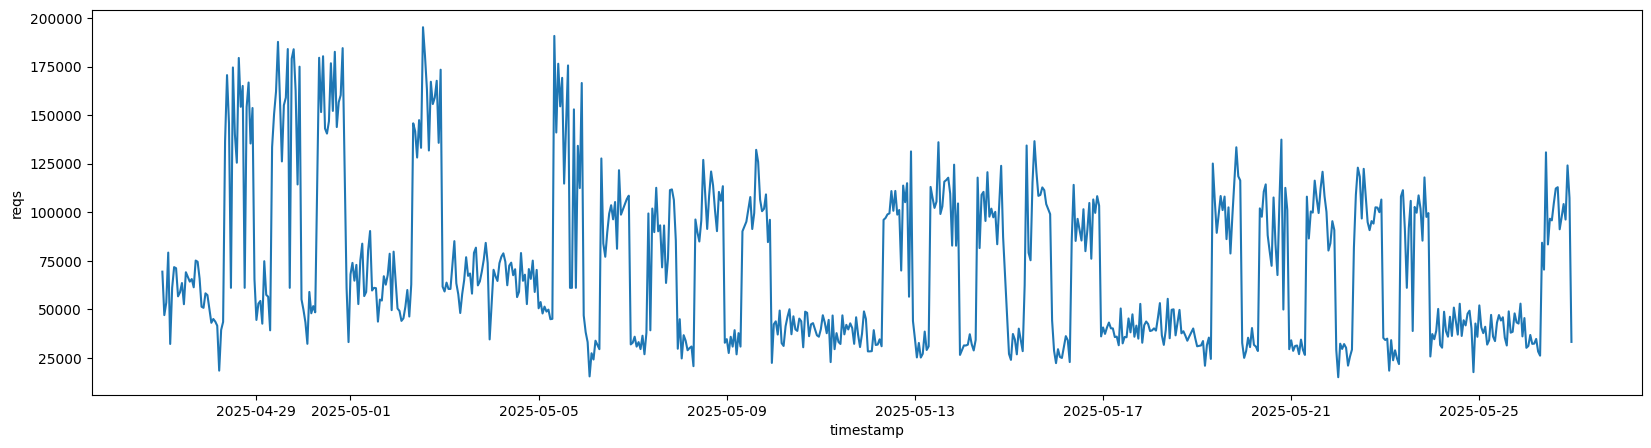

In [ ]:
# Ver como se comporta a variável alvo (reqs) ao longo do tempo
plt.figure(figsize = (20,5))
sns.lineplot(data = df, x = "timestamp", y = "reqs")

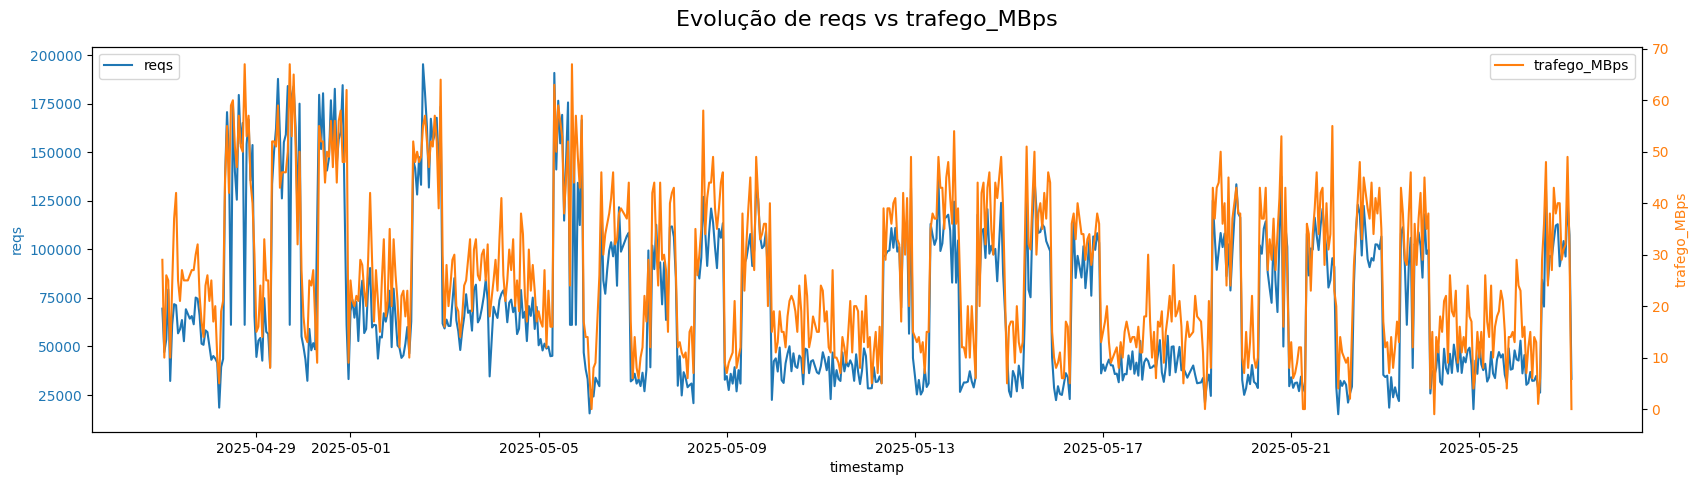

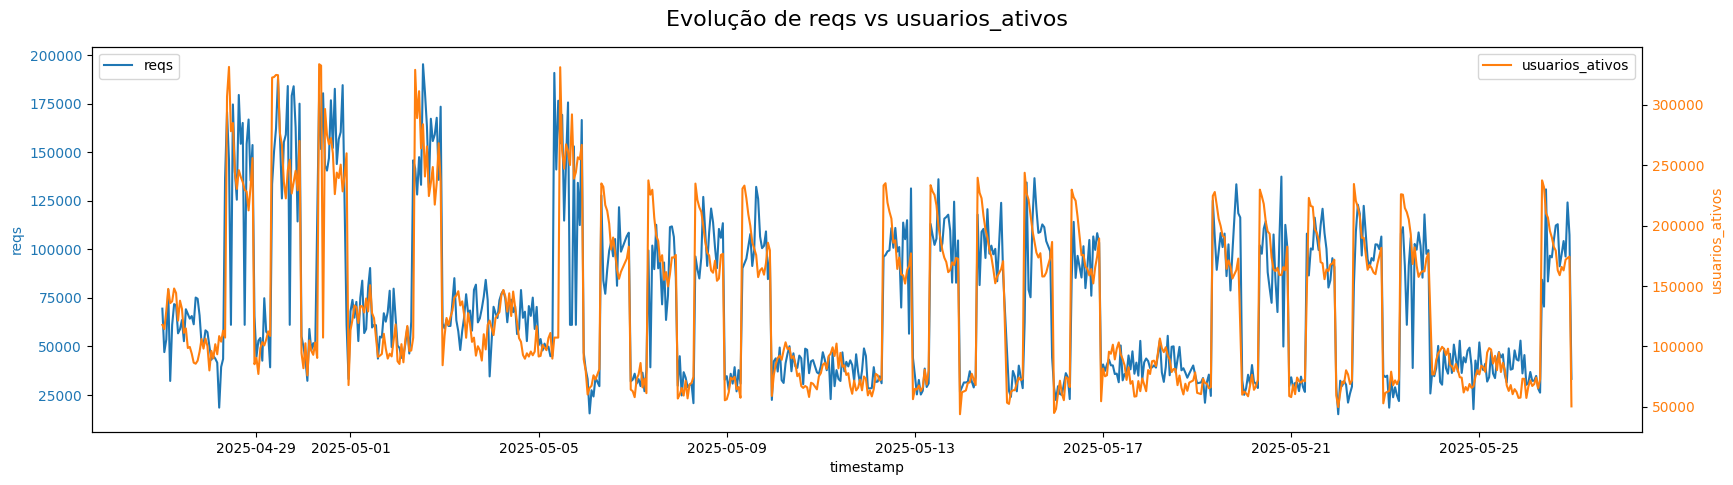

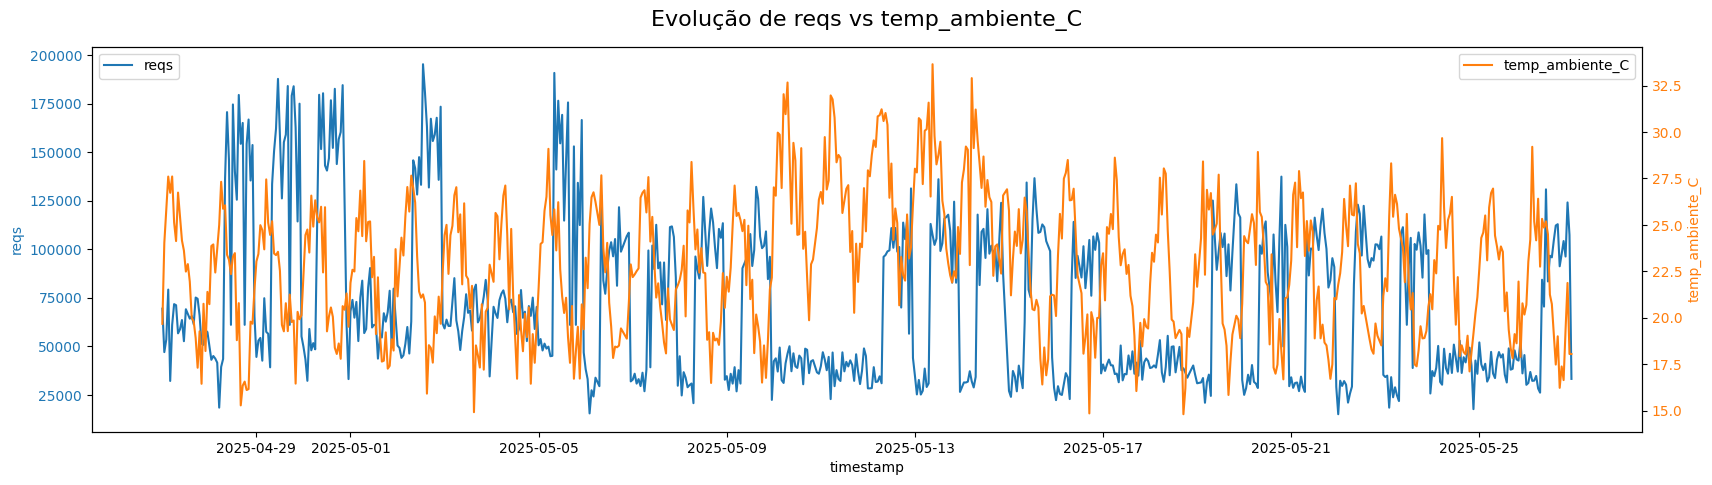

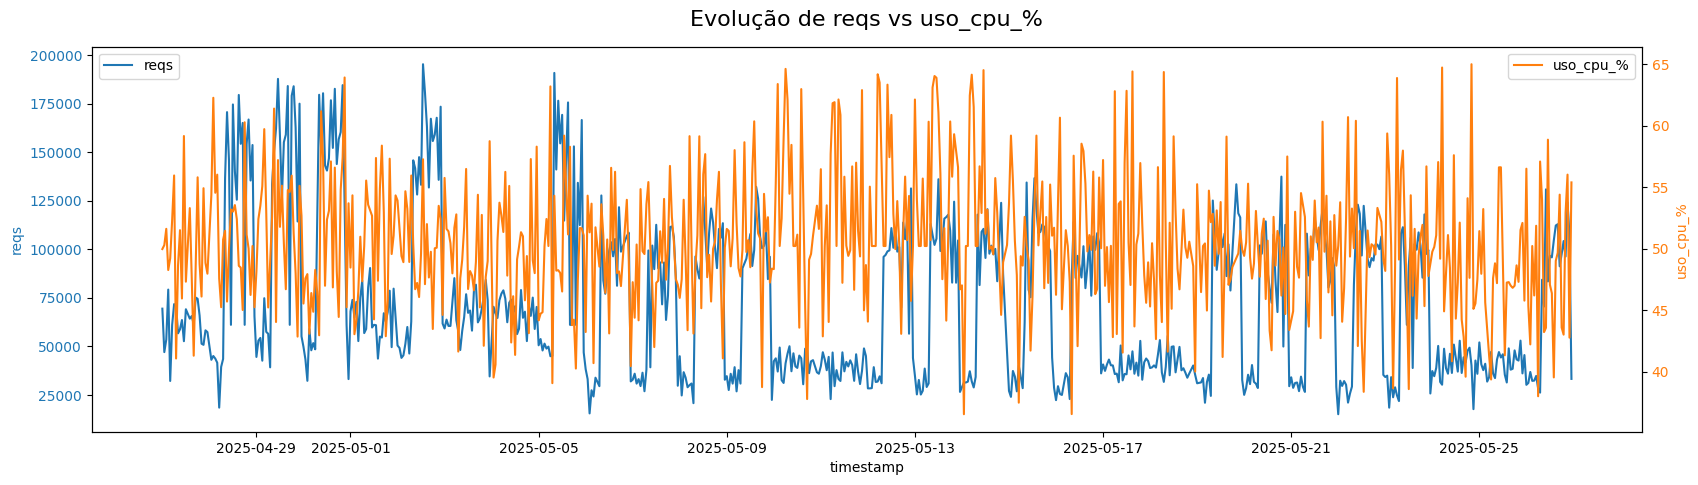

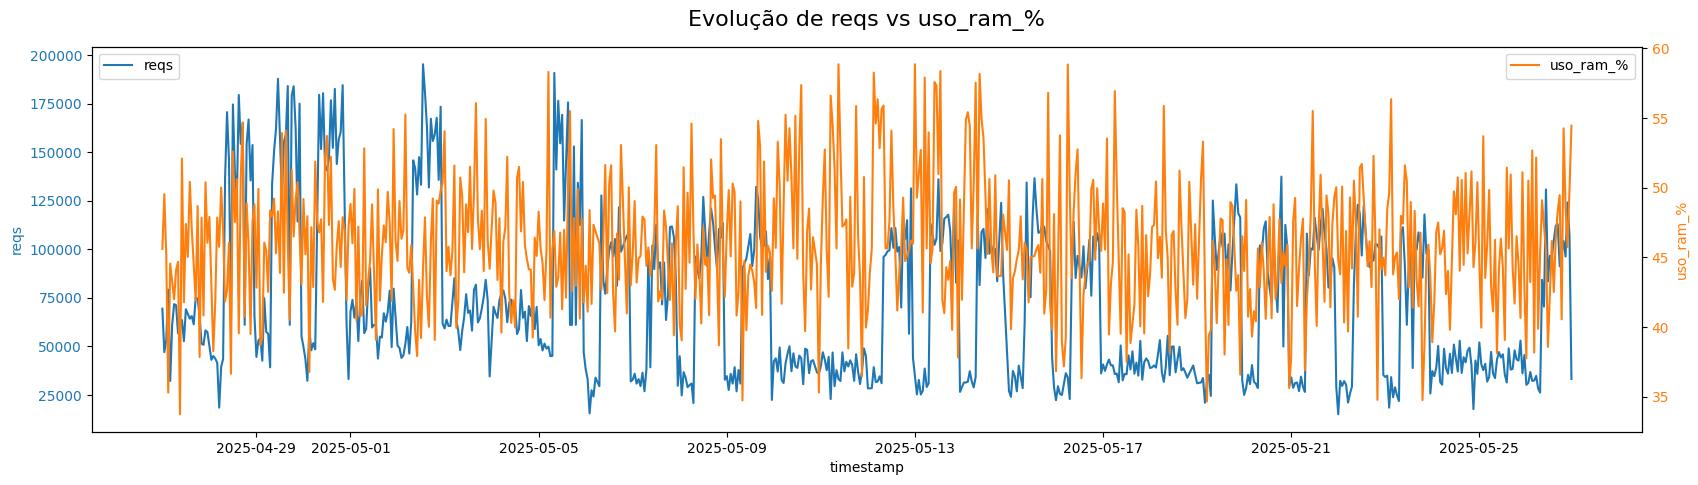

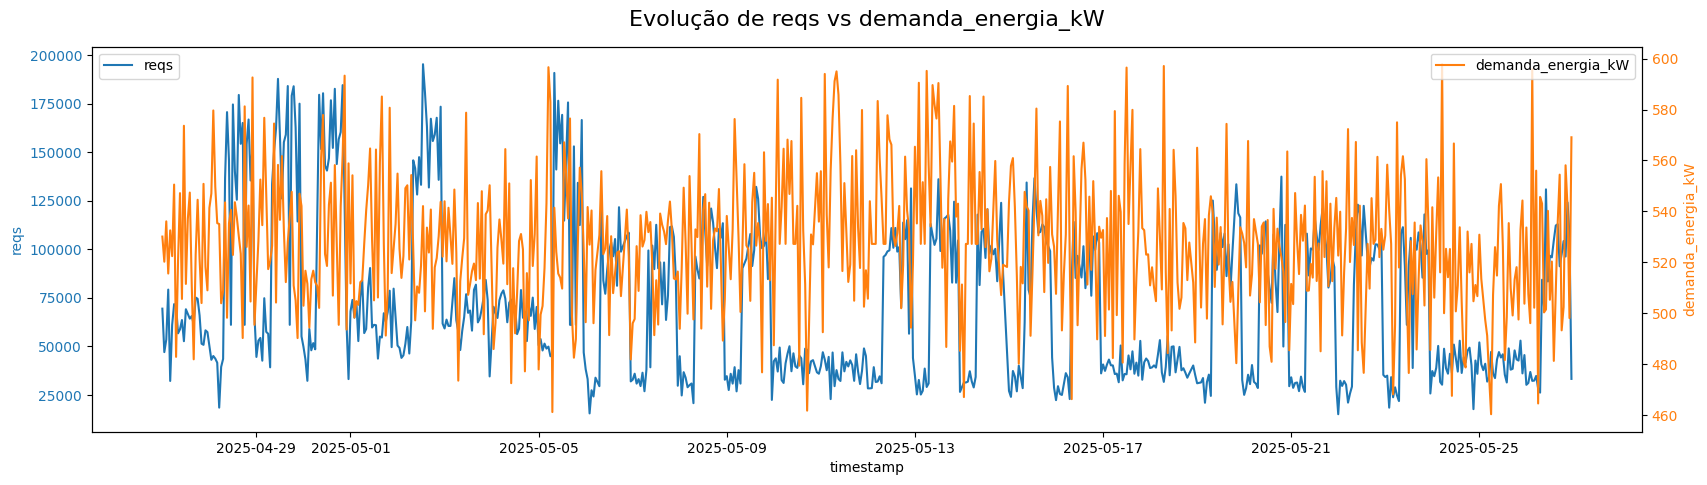

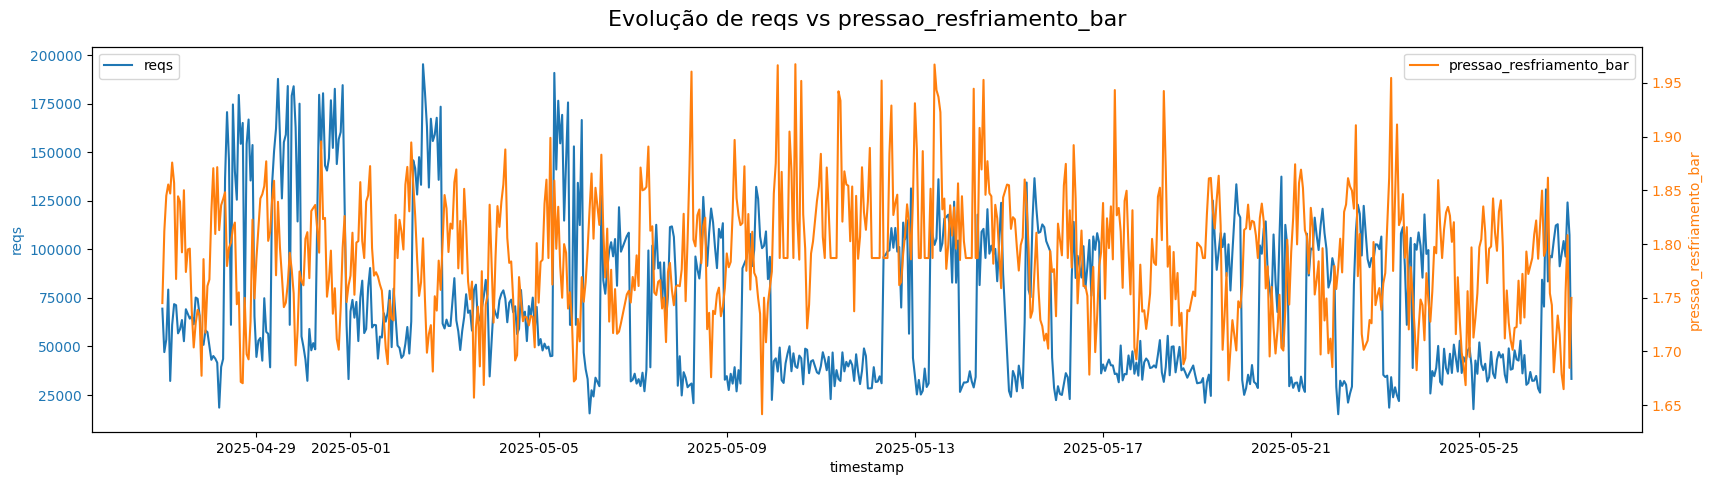

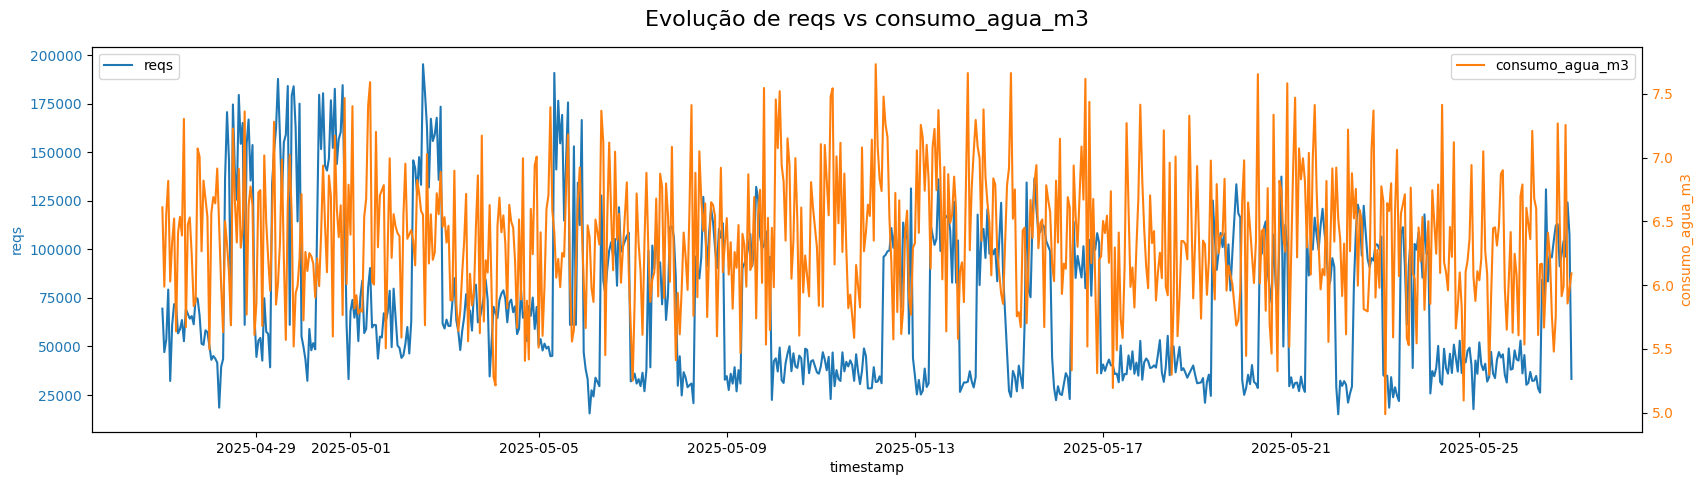

In [ ]:
# Ver como a variável alvo se comporta com as outras variáveis
features = ["trafego_MBps","usuarios_ativos","temp_ambiente_C","uso_cpu_%","uso_ram_%","demanda_energia_kW","pressao_resfriamento_bar","consumo_agua_m3"]

for feature in features:
    fig, ax1 = plt.subplots(figsize=(20, 5))

    # primeiro eixo (reqs)
    sns.lineplot(data=df, x="timestamp", y="reqs", ax=ax1, color="tab:blue", label="reqs")
    ax1.set_ylabel("reqs", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # segundo eixo (feature atual)
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x="timestamp", y=feature, ax=ax2, color="tab:orange", label=feature)
    ax2.set_ylabel(feature, color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    # título e legendas
    plt.title(f"Evolução de reqs vs {feature}", fontsize=16, pad=15)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.show()

<Axes: >

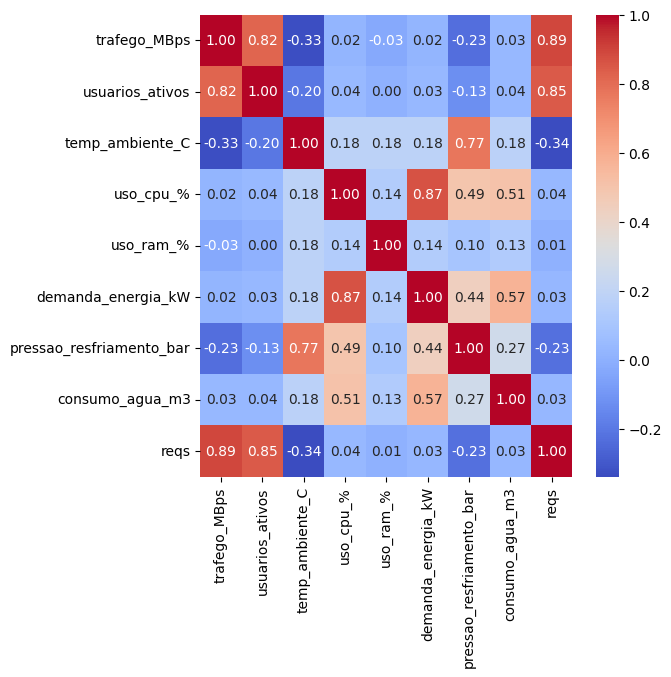

In [ ]:
corr_df = features.copy()
corr_df.append("reqs")

plt.figure(figsize=(6, 6))
sns.heatmap(df[corr_df].corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar=True)

- Variáveis mais correlacionadas com reqs são tráfego_MBPs e usuarios_ativos.

In [ ]:
#O dataframe tá na granularidade hora. Vou agrupar por dia pra ver o comportamento diariamente
df_day = df.groupby("date").agg(
    reqs=("reqs", "sum"),
    trafego_MBps=("trafego_MBps", "mean"),
    usuarios_ativos=("usuarios_ativos", "mean"),
    temp_ambiente_C=("temp_ambiente_C", "mean"),
    **{"uso_cpu_%": ("uso_cpu_%", "mean")},
    **{"uso_ram_%": ("uso_ram_%", "mean")},
    demanda_energia_kW=("demanda_energia_kW", "sum"),
    pressao_resfriamento_bar=("pressao_resfriamento_bar", "mean"),
    consumo_agua_m3=("consumo_agua_m3", "sum")
).reset_index()


<Axes: >

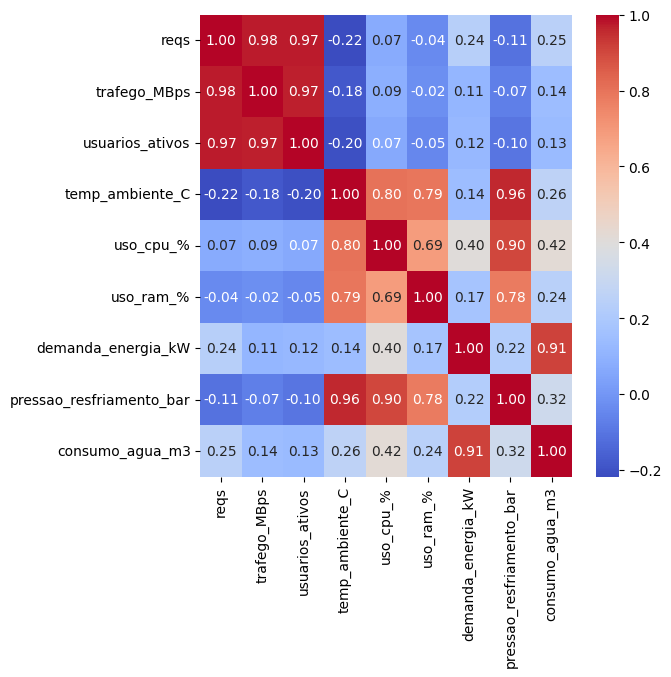

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(df_day.iloc[:,1:].corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar=True)

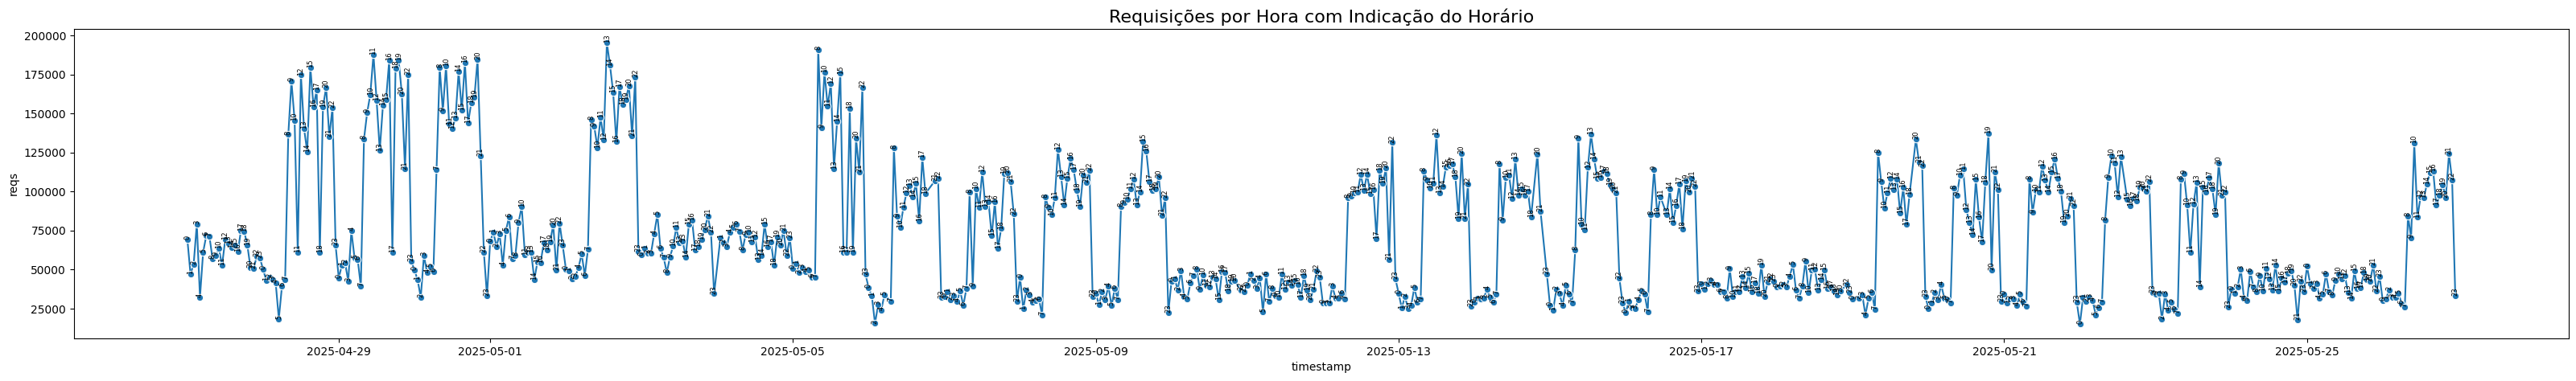

In [ ]:
plt.figure(figsize=(40,5))
sns.lineplot(data=df, x="timestamp", y="reqs", marker="o")

# adiciona anotações com a hora
for i, row in df.iterrows():
    plt.text(row["timestamp"], row["reqs"], row["timestamp"].hour,
             ha="center", va="bottom", fontsize=6, rotation=90)

plt.title("Requisições por Hora com Indicação do Horário", fontsize=16)
plt.show()


- Granularidade de hora e de dia da semana provavelmente

In [ ]:
df_day["timestamp"] = pd.to_datetime(df_day["date"])
df_day["day_of_week"] = df_day["timestamp"].dt.day_name()


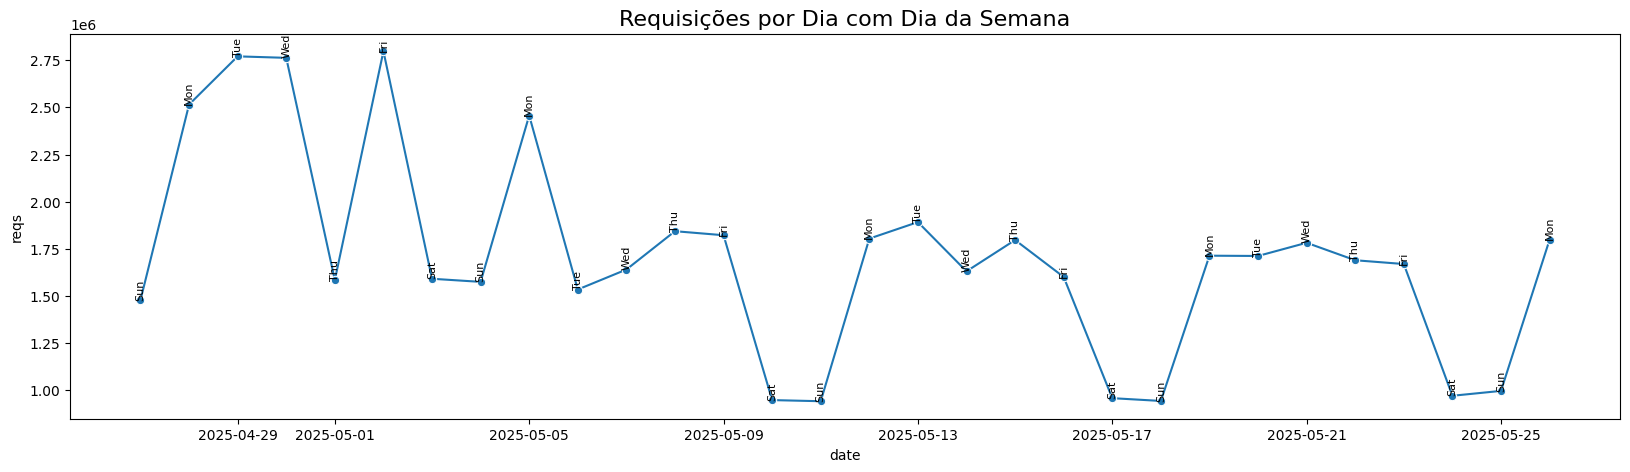

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_day, x="date", y="reqs", marker="o")

for i, row in df_day.iterrows():
    plt.text(row["date"], row["reqs"], row["day_of_week"][:3],
             ha="center", va="bottom", fontsize=8, rotation=90)

plt.title("Requisições por Dia com Dia da Semana", fontsize=16)
plt.show()
